# Comparison plots
This notebook aims to reproduce most of the plots in the discussion section of [Lochner et al. 2022](https://arxiv.org/abs/2104.05676), making use of the metrics bundle in the csv file produced by the OpSim team. 

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plot_tools
from scipy.interpolate import griddata
import george
from scipy.optimize import minimize

%matplotlib widget

In [49]:
metric_colors = {'fom':'C0',
            'lss':'C1',
            'wl':'C2',
            'sn':'C3',
            'sl':'C4',
            'snz':'C5',
            'kn':'C6',
            'pz':'C9'
        }

metric_markers = {'fom':'o',
        'lss':'^',
        'wl':'s',
        'sn':'*',
        'snz':'P',
        'sl':'D',
        'kn':'X',
        'pz':'+'
    }

## Select metrics to plot
We start by selecting which metrics we want to plot and provide shorter display names. In order to convert the metrics correctly for comparison, we need to know if any transforms need to be applied (see Lochner et al. 2022 for futher details). Possibilities include: <br>

invert = $1/x$ <br>
convert_to_flux = $10^{(-x/2.5)}$ <br>
convert_to_precision = $1/x^2$ <br>
one_minus = $1-2x$

In [23]:
metric_names = pd.read_csv('OS_metric_translations.csv', index_col=0)
metric_names.columns

Index(['desc_metric_name', 'desc_metric_display_name', 'maf_metric_v1_5_name',
       'maf_metric_v2_0_name', 'transform_invert', 'transform_mag_to_flux',
       'transform_to_precision', 'transform_one_minus', 'validated',
       'comment'],
      dtype='object')

## Metric files
When new simulations are run using the Feature Based Scheduler, a huge bundle of metrics are also run on those simulations and made available to the community. Try to stick to the latest file, starting with `summary_` available at: https://github.com/lsst-pst/survey_strategy/tree/main/fbs_2.0.

A summary of the v2.0 simulations is here: https://github.com/lsst-pst/survey_strategy/blob/main/fbs_2.0/SummaryInfo_v2.1.ipynb

This can also be updated for future versions of simulations.

While most of DESC's contributed metrics are available in this summary file, as of 3 October 2022 only a low-resolution approximation is available for the supernova (SN) metrics and we currently run those separately.

In [24]:
# Where the local copy of the summary file is
analysis_dir = 'FBS_analysis/' 

In [25]:
# maf_output_summary_file = analysis_dir + 'summary_2022_06_22_v2_0.txt'
maf_output_summary_file = analysis_dir + 'summary_2023_01_01.txt'
maf_output_full_v2 = pd.read_csv(maf_output_summary_file, index_col=0)

In [26]:
maf_columns = []
for idx in metric_names.index:
    maf_columns.append(metric_names.loc[idx, 'maf_metric_v2_0_name'])

In [27]:
maf_output = maf_output_full_v2[maf_columns]

In [35]:
baseline = 'baseline_v2.0_10yrs'

### Replace the approxmiate MAF SN metric with the DESC one run externally

In [29]:
sn_metrics_v2 = pd.read_csv(analysis_dir + 'SN_metric_v2.0_2022_07_27.csv', index_col=0)
sn_metrics_v2_1 = pd.read_csv(analysis_dir + 'SN_metric_v2.1_2022_07_27.csv', index_col=0)
sn_metrics = pd.concat((sn_metrics_v2, sn_metrics_v2_1))

There's a mismatch between the sims in the MAF summary file and the DESC SN metrics, so we have to restrict the indices

In [30]:
sn_indices = sn_metrics.index
maf_indices = maf_output.index
print(len(sn_indices), len(maf_indices))
intersection = list(set(sn_indices) & set(maf_indices))
print(len(intersection))

261 531
260


In [31]:
maf_output = maf_output.loc[intersection]

In [32]:
sn_metric_name = metric_names.loc['sn', 'maf_metric_v2_0_name']
maf_output.loc[intersection, sn_metric_name] = sn_metrics.loc[intersection, 'nsn']

## Compute the metrics relative to baseline
We always compare metrics by subtracting their value at baseline, and then dividing by their value at baseline. So all metrics can be considered as percentage improvement or degradation.

In [36]:
def compute_relative_improvement(metric_series, 
                                 baseline, 
                                 invert=False,
                                 convert_to_flux=False,
                                 convert_to_precision=False,
                                 one_minus=False):
    """
    Calculates the improvement of the metric over the given baseline, including applying the appropriate 
    transforms. Transforms are applied in the same order as used in Lochner et al. so for instance, a value
    will first be converted to flux and then to precision.
    """
    if convert_to_flux:
        metric_series = 10**(-metric_series/2.5)

    if one_minus:
        metric_series = 1 - 2*metric_series

    if invert:
        metric_series = 1/metric_series

    if convert_to_precision:
        metric_series = 1/metric_series**2
        
    baseline_value = metric_series.loc[baseline]
    
    return (metric_series - baseline_value)/baseline_value   

In [37]:
maf_output_rel = maf_output.copy()
for idx in metric_names.index:
    metric = metric_names.loc[idx, 'maf_metric_v2_0_name']
    rel_series = compute_relative_improvement(maf_output[metric], 
                                 baseline,
                                 metric_names.loc[idx, 'transform_invert'], 
                                 metric_names.loc[idx, 'transform_mag_to_flux'],
                                 metric_names.loc[idx, 'transform_to_precision'],
                                 metric_names.loc[idx, 'transform_one_minus'])
    maf_output_rel[metric] = rel_series

At this point, we have 3 important dataframes: <br>
- `metric_names`: contains a key for each metric, its nice display name and the long name in the MAF file
- `maf_output`: the original MAF summary file for all the metrics we care about (i.e. their raw values for each sim)
- `maf_output_rel`: the relative improvement for each metric over baseline, after each metric has been transformed appropriately

## Plotting functions
The functions we will use to make all the plots

### Comparison plot function
Plot many metrics as a function of a specific attribute.

In [76]:
def comparison_plot(metrics_original, metrics_rel, metric_names, x_axis, 
                    probes=[], themes={}, 
                    ylabel='', xlabel='', save_plot=False, savefig_path='', 
                    smoothing='none', nbins=20,
                    plot_baseline=True, baseline_name='baseline_v2.0_10yrs', expand_ylim_by=[1.1, 1.1]):
    """
    Plots a set of metrics against a summary parameter from the simulations (e.g. area, depth, cadence etc.)
    
    Parameters
    ----------
    metrics_original : pd.DataFrame
        The original values for all metrics (columns) for each simulation (row).
    metrics_rel : pd.DataFrame
        The metrics appropriately transformed and expressed as relative improvement over baseline for all 
        metrics (columns) for each simulation (row).
    metric_names: pd.DataFrame
        A translation between what the metric was called in the Lochner et al. paper and its name in the MAF summary file.
    x_axis: string
        Which metric to use on the x-axis
    probes: list of strings
        Which probes to plot, uses the short hand in "metric_names" to translate them. A good base set is 
        ['fom', 'wl', 'sn', 'kn', 'sl']
    themes: dict, optional
        Allows some probes to be plotted with fainter and thinner lines. Provide a dictionary for probes with values of
        either 0 (normal, thick lines) or 1 (fainter, thin lines). Defaults to 0 for all probes.
    ylabel: string, optional
        Label for y axis
    xlabel: string, optional
        Label for x axis
    save_plot: bool, optional
        Whether or not to save the figure to file
    savefig_path: string, optional
        Filename and path for the figure if saving it
    smoothing: string, optional
        Whether to plot all points ('none') or simplify the plot by binning points ('binning'). Generally binning is a
        good idea as there can be hundreds of simulations.
    nbins: int, optional
        Number of bins to use if smoothing='binning'
    plot_baseline: bool, optional
        If true (default), will plot a line with some text indicating the x axis value at baseline
    baseline_name: string, optional
        Which simulation to take as baseline (note this should be the same one used in calculating the relative metric
        values)
    expand_ylim_by: list, optional
        Two values to allow expanding of the y axis to accommodate large legends. E.g. [1.1, 1.4] will expand the top y
        limit of the plot by 40% of the maximum value.
        
    """

    # sim_annotation_numbers = {
    #     'footprint_big_sky_dustv1.5_10yrs': 1,
    #     'footprint_newAv1.5_10yrs' : 2,
    # }
    
    
    
    t0 = {'lw':2, 'alpha':1}
    t1 = {'lw':1, 'alpha':0.8}

    themes_translations = {0:t0, 1:t1}
    
    if len(list(themes.keys())) == 0:
        for p in probes:
            themes[p] = 0

    x_axis_metric = metric_names.loc[x_axis, 'maf_metric_v2_0_name']
    xvals = metrics_original.loc[metrics_rel.index, x_axis_metric].astype('float')
    inds = np.argsort(xvals)

    plt.figure()
    

    ylim = [0,0]

    for i in range(len(probes)):
        metric = metric_names.loc[probes[i], 'maf_metric_v2_0_name']

        yvals = metrics_rel.loc[metrics_rel.index, metric].astype('float')

        x = xvals[inds].values
        y = yvals[inds].values

        unique_x = np.unique(x)
        unique_y = np.zeros(len(unique_x))

        for k in range(len(unique_x)):
            msk = x == unique_x[k]
            if sum(msk) == 1:
                unique_y[k] = y[msk]
            else:
                unique_y[k] = y[msk].mean()

        x = unique_x
        y = unique_y

        if smoothing == 'none':
            new_x = x
            new_y = y
            yerr = np.zeros(len(new_x))

        elif smoothing == 'binning':
            xgrid = np.linspace(x.min(), x.max(), nbins)
            x_delt = xgrid[1] - xgrid[0]
            new_x = []
            new_y = []
            yerr = []

            for k in range(len(xgrid)):
                msk = (x>=xgrid[k]) & (x<xgrid[k] + x_delt)
                if msk.sum() == 0:
                    pass
                elif msk.sum() == 1:
                    new_x.append(x[msk][0])
                    new_y.append(y[msk][0])
                    yerr.append(0)
                else:
                    new_x.append(x[msk].mean())
                    new_y.append(y[msk].mean())
                    yerr.append(y[msk].std())

            new_x = np.array(new_x)
            new_y = np.array(new_y)
            yerr = np.array(yerr)
            

        theme = themes_translations[themes[probes[i]]]
        plt.errorbar(new_x, new_y, yerr=yerr, marker=None,
                  lw=theme['lw'], alpha=theme['alpha'], 
                 color=metric_colors[probes[i]])
        plt.plot(new_x, new_y, marker=metric_markers[probes[i]],
                 label=metric_names.loc[probes[i], 'desc_metric_display_name'], lw=0,
                 linestyle=None, alpha=theme['alpha'], color=metric_colors[probes[i]])

        if (new_y+yerr).max() > ylim[1]:
            ylim[1] = (new_y+yerr).max()
        if (new_y-yerr).min() < ylim[0]:
            ylim[0] = (new_y-yerr).min()
        

        # Relic code to apply annotations to the plot. Left in just in case we need it again.
#     if len(annotations) != 0:
#         anno_x = []
#         anno_y = []
#         anno_sim = []
#         anno_num = []
#         for k in annotations.keys():
#             which_probe = annotations[k][0]
#             metric = probes_translations[which_probe]
#             yshift = -0.06 + annotations[k][1]
#             xtext = misc_metrics.loc[k, x_axis].astype('float')
#             ytext = metrics_rel.loc[k, metric].astype('float') + yshift
#             anno_x.append(xtext)
#             anno_y.append(ytext)
#             anno_sim.append(k)
#             anno_num.append(sim_annotation_numbers[k])

#         sorted_inds = np.argsort(anno_x)
#         counter = 1
#         print_str = 'Annotations: '
#         for ind in sorted_inds:
#             plt.text(anno_x[ind], anno_y[ind], (str)(counter), color='k')
#             # plt.text(anno_x[ind], anno_y[ind], (str)(anno_num[ind]), color='k')
#             sim_name = anno_sim[ind]
#             sim_name = sim_name.replace('_', '\_')
#             print_str += '%d-\\texttt{%s}, ' %(counter, sim_name)
#             # print_str += '%d-\\texttt{%s}, ' %(anno_num[ind], sim_name)
#             counter += 1
#         print(print_str[:-2]) 

    # handles, labels = plt.gca().get_legend_handles_labels()
    # # remove the errorbars
    # print(handles[0][0])
    # handles = [h[0] for h in handles]
    # print(handles[0])
 
    # plt.legend(handles, labels, numpoints=1, loc='best')
    plt.legend(loc='best')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    

    ax = plt.gca()
    new_ylim = [ylim[0]*expand_ylim_by[0], ylim[1]*expand_ylim_by[1]]
    new_xlim = ax.get_xlim()
    
   
    zo = 0

    plt.plot(new_xlim, [0, 0], '--k', alpha=0.5, zorder=zo)

    if plot_baseline:

        base_val = float(metrics_original.loc[baseline_name, x_axis_metric])
        plt.plot([base_val, base_val], new_ylim, '--k', lw=1, alpha=0.3,
                 zorder=zo)
        plt.text(base_val, new_ylim[1]*0.8, 'baseline', 
                alpha=0.3, zorder=zo)


    plt.xlim(new_xlim)
    plt.ylim(new_ylim)
    plt.tight_layout()
    
    if len(savefig_path) != 0 and save_plot:
        plt.savefig(savefig_path)

### Individual sims plot function
Function to plot a set of simulations for some metrics

In [94]:
def plot_individual_sims(metrics_rel, metric_names, list_of_sims, probes=[], ylabel='', xlabel='',
                         save_plot=False, savefig_path='', expand_ylim_by=[1.1, 1.1],
                         legend_outside=False, figsize=(8,4)):
    """
    Plots the relative metrics for a subset of simulations.
    
    Parameters
    ----------
    metrics_rel : pd.DataFrame
        The metrics appropriately transformed and expressed as relative improvement over baseline for all 
        metrics (columns) for each simulation (row).
    metric_names: pd.DataFrame
        A translation between what the metric was called in the Lochner et al. paper and its name in the MAF summary file.
    list_of_sims: list of strings
        Which simulations to plot on the x axis. Note this should be a short list to maintain readability.
    probes: list of strings
        Which probes to plot, uses the short hand in "metric_names" to translate them. A good base set is 
         ['fom', 'wl', 'sn', 'kn', 'sl']
    ylabel: string, optional
        Label for y axis
    xlabel: string, optional
        Label for x axis
    save_plot: bool, optional
        Whether or not to save the figure to file
    savefig_path: string, optional
        Filename and path for the figure if saving it
    expand_ylim_by: list, optional
        Two values to allow expanding of the y axis to accommodate large legends. E.g. [1.1, 1.4] will expand the top y
        limit of the plot by 40% of the maximum value.
    legend_outside: bool, optional
        If true, will place the legend outside the plot area. The figure size may need to be adjusted.
    figsize: tuple, optional
        Matplotlib figsize
        
    """
                         
    plt.figure(figsize=figsize)
    x = np.arange(len(list_of_sims))
    xlim = [-0.1, len(x)-1+0.1]
    plt.plot(xlim, [0]*len(xlim), 'k--', alpha=0.5)
    
    for p in probes:
        metric = metric_names.loc[p, 'maf_metric_v2_0_name']
        y = metrics_rel.loc[list_of_sims, metric].astype('float')
        plt.plot(x, y, label=metric_names.loc[p, 'desc_metric_display_name'], 
                 color=metric_colors[p], marker=metric_markers[p])
        
    plt.xticks(x, list_of_sims, rotation=90)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    if legend_outside:
        plt.legend(bbox_to_anchor=(1.1, 1.00))
    else:
        plt.legend()
    
    ax = plt.gca()
    ylim = ax.get_ylim()
    new_ylim = [ylim[0]*expand_ylim_by[0], ylim[1]*expand_ylim_by[1]]
    plt.ylim(new_ylim)
    plt.xlim(xlim)
    plt.tight_layout()

    if len(savefig_path) != 0 and save_plot:
        plt.savefig(savefig_path)

In [39]:
probes_to_plot = ['fom', 'wl', 'sl', 'sn', 'kn']
y_label = '(metric - baseline)/baseline'

## Metric comparison plots

### Area

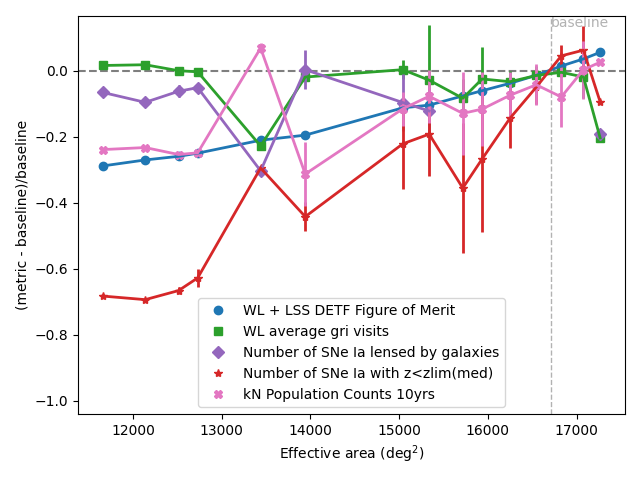

In [40]:
comparison_plot(maf_output, maf_output_rel, metric_names, 'area', probes=probes_to_plot, smoothing='binning',
               expand_ylim_by=[1.5, 1.2], xlabel='Effective area (deg$^2$)', ylabel=y_label)

### Median i-band depth in effective area

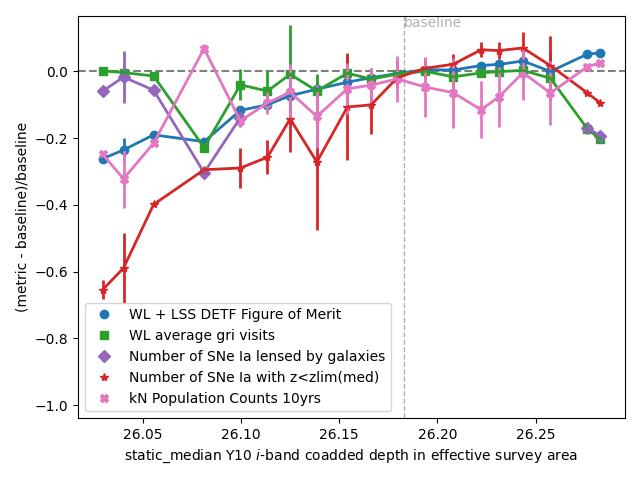

In [41]:
comparison_plot(maf_output, maf_output_rel, metric_names, 'depth', probes=probes_to_plot, smoothing='binning',
               expand_ylim_by=[1.5, 1.2], xlabel='static_median Y10 $i$-band coadded depth in effective survey area', 
               ylabel=y_label)

### Combined metric

In [42]:
def calculate_combined_metric(metrics_rel):
    frac_static = 0.5
    frac_sn = 0.5
    
    sn = metrics_rel[metric_names.loc['sn', 'maf_metric_v2_0_name']]
    fom = metrics_rel[metric_names.loc['fom', 'maf_metric_v2_0_name']]
    
    return frac_static*fom + frac_sn*sn

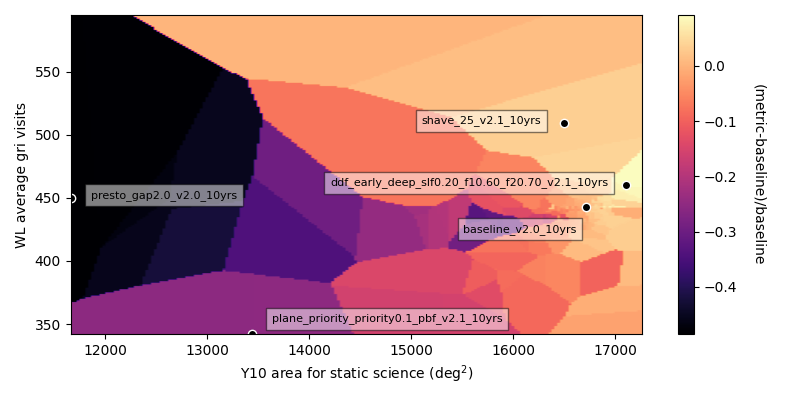

In [43]:
combined_metric = calculate_combined_metric(maf_output_rel)
maf_output_rel['combined'] = combined_metric

xaxis = 'area'
yaxis = 'wl'

xaxis_metric = metric_names.loc[xaxis, 'maf_metric_v2_0_name']
yaxis_metric = metric_names.loc[yaxis, 'maf_metric_v2_0_name']
# maf_output.loc[maf_output_rel.index, metric_names.loc['depth', 'maf_metric_v2_0_name']]

X = np.array([maf_output.loc[maf_output_rel.index, xaxis_metric],
              maf_output.loc[maf_output_rel.index, yaxis_metric]
             ]).T
Z = np.array(maf_output_rel.combined)

xmin = X[:,0].min()
xmax = X[:,0].max()
ymin = X[:,1].min()
ymax = X[:,1].max()


extent = xmin, xmax, ymin, ymax

X[:,0] = (X[:,0] - xmin)/(xmax-xmin)
X[:,1] = (X[:,1] - ymin)/(ymax-ymin)


labels = [
         'presto_gap2.0_v2.0_10yrs',
         baseline,
         'ddf_early_deep_slf0.20_f10.60_f20.70_v2.1_10yrs',
         'shave_25_v2.1_10yrs',
         'plane_priority_priority0.1_pbf_v2.1_10yrs'
         ]

xlabs = []
ylabs = []


xshift = [200]*len(labels)
# xshift[0] = 100
xshift[1] = -1200
xshift[2] = -2900
xshift[3] = -1400


yshift = [0]*len(labels)
yshift[1] = -20
yshift[4] = 10


# if show_footprint_8:
#     xshift[5] = -400
#     xshift[6] = 100


# descriptions = pd.read_excel('bar_graph_data.xlsx', sheet_name='descriptions', index_col=0)

# if show_footprint_8:
#     descriptions.loc['baseline_v1.4_10yrs.db', 'short'] = 'Baseline v1.5'
#     descriptions.loc['footprint_big_sky_dustv1.4_10yrs.db', 'short'] = 'FootprintBigSky'
#     descriptions.loc['baseline_nexp2_v1.7_10yrs.db'] = ['Baseline v1.7', 'Baseline v1.7']
#     descriptions.loc['footprint_8_v1.710yrs.db'] = ['Footprint8', 'Footprint8']
    


for i in range(len(labels)):
    l = labels[i]
    xlab = maf_output.loc[l, xaxis_metric]
    ylab = maf_output.loc[l, yaxis_metric]

#     xlabs.append((xlab-xmin)/(xmax-xmin))
#     ylabs.append((ylab-ymin)/(ymax-ymin))
    xlabs.append(xlab)
    ylabs.append(ylab)

plt.close('all')
x = np.linspace(X[:,0].min(), X[:,0].max(), 200)
y = np.linspace(X[:,1].min(), X[:,1].max(), 200)
xgrid, ygrid = np.meshgrid(x, y)
zgrid = griddata(X, Z, (xgrid, ygrid), method='nearest')

plt.figure(figsize=(8,4))

for i in range(len(labels)):
    plt.plot(xlabs[i], ylabs[i], 'ok', markeredgecolor='w')
#         this_text = labels[i]
#         if '.db' in this_text:
#             this_text = this_text[:-3]
#         if '_10yrs' in this_text:
#             this_text = this_text[:-6]
    ind = labels[i]+'.db'
    # this_text = descriptions.loc[ind, 'short']
    this_text = labels[i]
    plt.text(xlabs[i]+xshift[i], ylabs[i]+yshift[i], this_text, usetex=False, 
             fontsize=8,bbox=dict(facecolor='white', alpha=0.5))

im1=plt.imshow(zgrid, origin='lower', extent=extent, aspect='auto', cmap='magma')
# l1, l2 = 4,2
# l3, l4 = 6,5
# if show_footprint_8:
#     plt.plot([xlabs[l1], xlabs[l2]], [ylabs[l1], ylabs[l2]], 'w-')
#     plt.plot([xlabs[l3], xlabs[l4]], [ylabs[l3], ylabs[l4]], 'w--')
plt.plot([])
cbar = plt.colorbar()
cbar.set_label('(metric-baseline)/baseline', rotation=-90, labelpad=20)
# cbar.set_label('KN (relative to baseline)', rotation=-90, labelpad=20)

plt.xlabel(metric_names.loc[xaxis, 'desc_metric_display_name'])
# plt.ylabel('Median $i$-band depth')
plt.ylabel(metric_names.loc[yaxis, 'desc_metric_display_name'])
plt.tight_layout()
# plt.savefig(fig_dir+'mega_metric')
# plt.savefig(fig_dir+'kn_combined.png')
# plt.savefig(fig_dir+'sl_combined.png')
#     plt.savefig(fig_dir+'nvists_depth_combined.png')

### Filter distribution

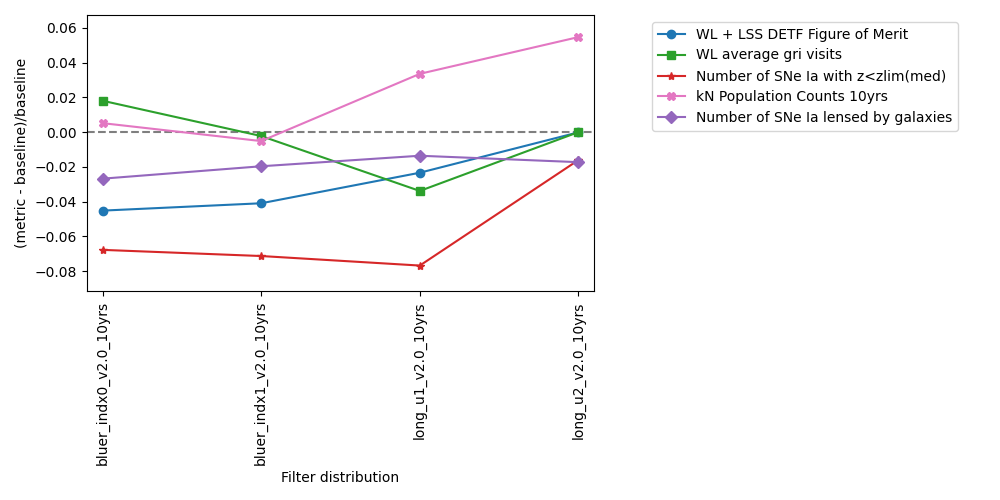

In [99]:
filter_change_sims = []
for idx in maf_output.index:
    if 'bluer' in idx or 'long_u' in idx:
        filter_change_sims.append(idx)
filter_change_sims.sort()

probes = ['fom', 'wl', 'sn', 'kn', 'sl']

plot_individual_sims(maf_output_rel, metric_names, filter_change_sims, probes=probes, ylabel=y_label, 
                     xlabel = 'Filter distribution', expand_ylim_by=[1.1, 1.1], figsize=(10,5), legend_outside=True)

### Visit pairs

#### Presto family

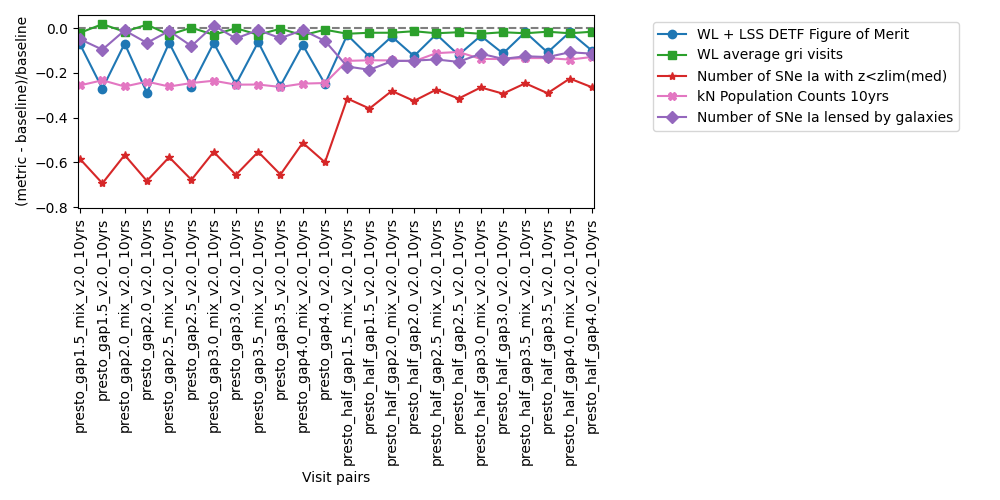

In [101]:
list_of_sims = []
for idx in maf_output.index:
    if 'presto' in idx:
        list_of_sims.append(idx)
list_of_sims.sort()

probes = ['fom', 'wl', 'sn', 'kn', 'sl']

plot_individual_sims(maf_output_rel, metric_names, list_of_sims, probes=probes, ylabel=y_label, 
                     xlabel = 'Visit pairs', expand_ylim_by=[1.1, 1.1], figsize=(10,5), legend_outside=True)

#### Long gap family

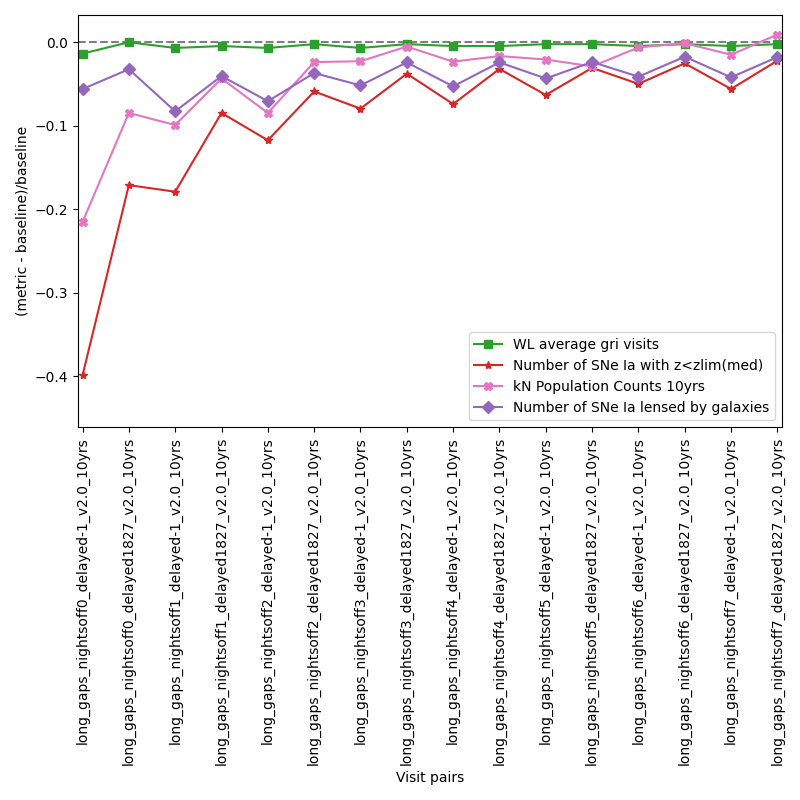

In [109]:
list_of_sims = []
for idx in maf_output.index:
    if 'long_gaps' in idx and 'np_' not in idx:
        list_of_sims.append(idx)
list_of_sims.sort()

probes = ['wl', 'sn', 'kn', 'sl']

plot_individual_sims(maf_output_rel, metric_names, list_of_sims, probes=probes, ylabel=y_label, 
                     xlabel = 'Visit pairs', expand_ylim_by=[1.1, 1.1], figsize=(8,8), legend_outside=False)

#### Long gap family - NP

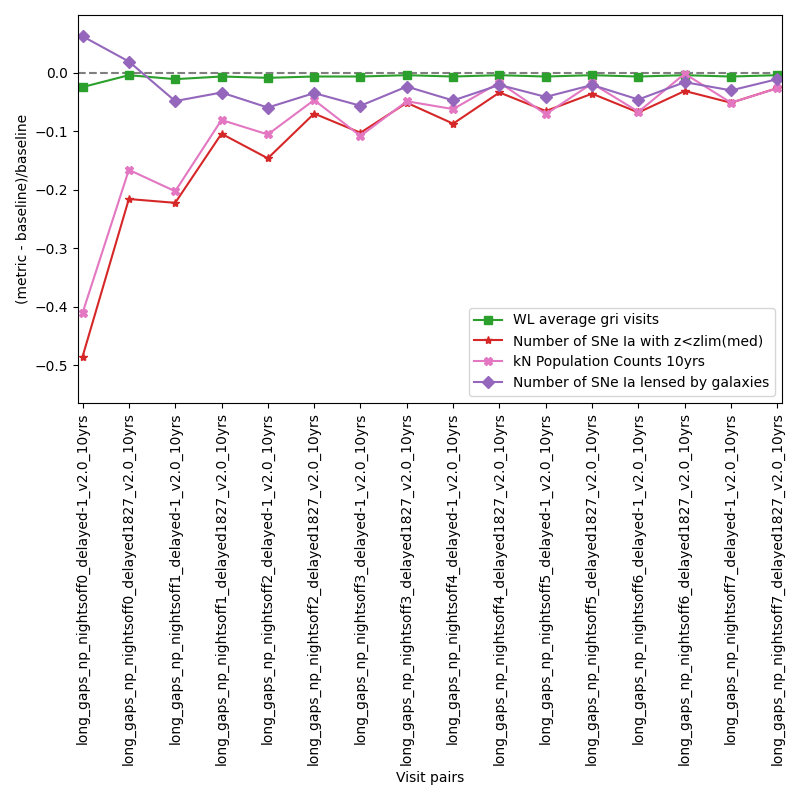

In [108]:
list_of_sims = []
for idx in maf_output.index:
    if 'long_gaps' in idx and 'np_' in idx:
        list_of_sims.append(idx)
list_of_sims.sort()

probes = ['wl', 'sn', 'kn', 'sl']

plot_individual_sims(maf_output_rel, metric_names, list_of_sims, probes=probes, ylabel=y_label, 
                     xlabel = 'Visit pairs', expand_ylim_by=[1.1, 1.1], figsize=(8,8), legend_outside=False)

### Exposure time?

### Median inter-night gap all bands

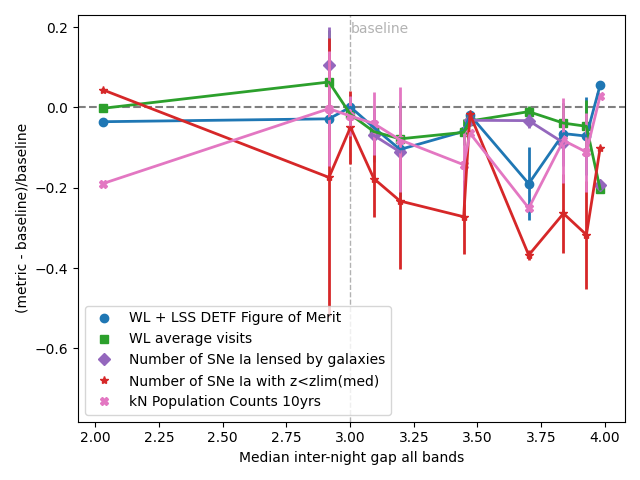

In [90]:
comparison_plot(maf_output, maf_output_rel, metric_names, 'internight_gap', probes=probes_to_plot, smoothing='binning',
               expand_ylim_by=[1.5, 1.2], xlabel='Median inter-night gap all bands', ylabel=y_label)

### Median inter-night gap per band

In [95]:
metric_names.loc['internight_gap_filter']

desc_metric_name                                                          NaN
desc_metric_display_name                                                  NaN
maf_metric_v1_5_name        Median Median Inter-Night Gap r band HealpixSl...
maf_metric_v2_0_name        Median Median Inter-Night Gap WFD r band Healp...
transform_invert                                                        False
transform_mag_to_flux                                                   False
transform_to_precision                                                  False
transform_one_minus                                                     False
validated                                                                   ?
comment                                                                   NaN
Name: internight_gap_filter, dtype: object

/tmp/ipykernel_5873/4264553327.py:78: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


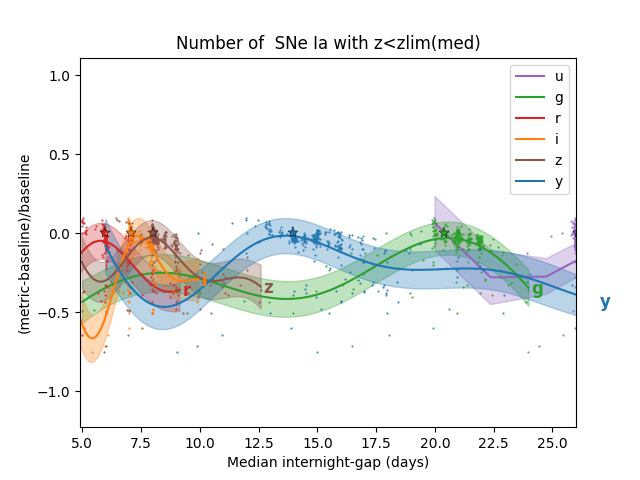

In [102]:
bands = ['u','g','r','i','z','y']
cols = ['C4', 'C2', 'C3', 'C1', 'C5', 'C0']
normalise_x = False
# which_metric = 'kn_Pop_kNe_counts'
which_metric = metric_names.loc['sn', 'maf_metric_v2_0_name']
# which_metric = 'static_median Y10 $i$-band coadded depth in effective survey area'
# which_metric = 'pz_y10_zlow_stdd'
# which_metric = 'sl_num_lensed_SNe_Ia_with_good_time_delays_lensed_by_galaxies'
# which_metric = 'fONv MedianNvis fO All visits HealpixSlicer'

        
# col = 'fONv MedianNvis fO All visits HealpixSlicer'
# inds = misc_metrics.loc[inds][(misc_metrics.loc[inds, col]<=1000)&(misc_metrics.loc[inds, col]>=900)].index

k = 0
plt.figure()
for b in bands:
    x_axis = metric_names.loc['internight_gap_filter', 'maf_metric_v2_0_name'].replace('r band', f'{b} band')
    
    ####### **** CHANGE
    x = maf_output_full_v2.loc[maf_output_rel.index, x_axis]
    if normalise_x:
        x = (x-x.min())/(x.max()-x.min())
    y = maf_output_rel[which_metric]
    
    
#     y = misc_metrics.loc[inds, which_metric]
    #x = x/misc_metrics.loc[inds, 'Median Median Inter-Night Gap all bands HealpixSlicer']
#     x = x*misc_metrics.loc[inds, 'fONv MedianNvis fO All visits HealpixSlicer']

    kernel = george.kernels.ExpSquaredKernel((x.max()-x.min()))

    gp = george.GP(kernel, fit_mean=True, fit_white_noise=True)
    gp.compute(x, y.std())

    def neg_ln_like(p):
            gp.set_parameter_vector(p)
            return -gp.log_likelihood(y)

    def grad_neg_ln_like(p):
        gp.set_parameter_vector(p)
        return -gp.grad_log_likelihood(y)

    result = minimize(neg_ln_like, gp.get_parameter_vector(),
                              jac=grad_neg_ln_like, method="L-BFGS-B",
                              tol = 1e-5)
    gp.set_parameter_vector(result.x)

    pred_x = np.linspace(x.min(), x.max(), 100)
    pred_y, y_var = gp.predict(y, pred_x, return_var=True)
    other_pred_y = gp.predict(y, x, return_cov=False)
    
    new_x = pred_x
    new_y = pred_y
    
    y_err = np.sqrt(y_var+(y-other_pred_y).std()**2)
    
    baseline_x = maf_output_full_v2.loc[baseline,x_axis]
    baseline_y = 0

    if not normalise_x:
        plt.fill_between(new_x, new_y-y_err, new_y+y_err, color=cols[k], alpha=0.3)
    plt.plot(new_x, new_y, color=cols[k], label=b)
    
    plt.plot(x, y, '.', markersize=1, color=cols[k]
        )
    plt.plot(baseline_x, baseline_y, '*', markersize=8, 
             markerfacecolor=cols[k], markeredgecolor='k', markeredgewidth=0.3)
    plt.text(new_x.max()+0.1, new_y[new_x.argmax()]-0.04, '$\mathbf{%s}$' %b, color=cols[k], fontsize=12)
    k+=1
plt.xlabel('Median internight-gap (days)')
plt.ylabel('(metric-baseline)/baseline')
plt.title('Number of  SNe Ia with z<zlim(med)')
plt.legend()
if not normalise_x:
    plt.xlim([4.9,26])
#     plt.ylim([-0.15, 0.05])
plt.tight_layout()


### Cumulative season length

### Weather?